In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
from xgboost import XGBClassifier
import shap
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Load dicts
with open("playoff_dict.json") as f:
    playoff_dict = json.load(f)
playoff_dict = {int(k): v for k, v in playoff_dict.items()}

with open("division_winners_dict.json") as f:
    division_winners_dict = json.load(f)
division_winners_dict = {int(k): v for k, v in division_winners_dict.items()}

In [4]:
# Function to get training data
def get_training_data(data, season, year_back, playoff_dict, top_seed_dict):
    # Select data from past seasons within the training window size
    train = data[(data["season"] < season) & (data["season"] >= (season - year_back))].copy()
    
    # Create playoff label: 1 if team made the playoffs, else 0
    train["is_playoff"] = train.apply(lambda row: int(row["team"] in playoff_dict.get(row["season"], [])), axis=1)

    # Separate features and labels for playoff model
    X_playoff = train.drop(columns=["team", "season", "week", "result", "is_champion", "is_playoff"])
    y_playoff = train["is_playoff"]

    # Subset only playoff teams for champion model
    X_champion = X_playoff[y_playoff == 1]
    y_champion = train["is_champion"][y_playoff == 1]

    # Assign higher weight to top seed teams
    sample_weights = train.apply(
    lambda row: 2.5 if row["team"] in top_seed_dict.get(row["season"], []) else 1.0,
    axis=1
    )
    sample_weights = sample_weights[y_playoff == 1]

    return X_playoff, y_playoff, X_champion, y_champion, sample_weights


# Function to train the two-stage model (playoff model and champion model)
def train_models(X, y_playoff, X_champion, y_champion, sample_weights):
    # Train playoff prediction model
    playoff_model = XGBClassifier(eval_metric="logloss", random_state=42)
    playoff_model.fit(X, y_playoff)

    # Train champion prediction model using playoff teams with weighted samples
    champion_model = XGBClassifier(eval_metric="logloss", random_state=42)
    champion_model.fit(X_champion, y_champion, sample_weight=sample_weights)

    return playoff_model, champion_model


# Function to get season data for prediction
def get_season_data(data, season, year_back):
    # Select seasons within the training window size
    relevant_seasons = [season - i for i in range(1, year_back + 1)]
    season_data = data[data["season"].isin(relevant_seasons)]

    # Calculate number of games per team
    games_per_team = season_data.groupby("team")["week"].count().rename("games_played")

    # Aggregate team-level statistics
    season_data = season_data.groupby("team").agg({
        'total_yards': 'mean',
        'def_yards_allowed': 'mean',
        'turnovers': 'sum',
        'possession_time': 'mean',
        'pass_yards': 'mean',
        'rush_yards': 'mean',
        'third_down_pct': 'mean',
        'redzone_pct': 'mean',
        'point_diff': 'sum',
        'ypp': 'mean'
    })

    # Normalise turnover and point differential per game
    season_data = season_data.merge(games_per_team, left_index=True, right_index=True)
    season_data["turnovers"] = season_data["turnovers"] / season_data["games_played"]
    season_data["point_diff"] = season_data["point_diff"] / season_data["games_played"]
    season_data = season_data.drop(columns=["games_played"])
    
    return season_data.reset_index()


# Function to predict and rank team championship probabilities for 2025 using two-stage model
def predict_championship_2025(playoff_model, champion_model, season_data):
    # Prepare input features
    X_test = season_data.drop(columns=["team"])

    # Predict playoff probabilities
    playoff_probs = playoff_model.predict_proba(X_test)[:, 1]

    # Predict champion probabilities
    champ_probs = champion_model.predict_proba(X_test)[:, 1]

    # Final championship probability
    final_probs = playoff_probs * champ_probs

    # Build ranked DataFrame
    ranked = season_data[["team"]].copy()
    ranked["prob"] = final_probs
    ranked = ranked.sort_values("prob", ascending=False).reset_index(drop=True)

    # Normalise probabilities and convert to percentage
    total_prob = ranked["prob"].sum()
    ranked["normalized_prob"] = ranked["prob"] / total_prob
    ranked["Championship Probability (%)"] = (ranked["normalized_prob"] * 100).round(3)

    return ranked[["team", "Championship Probability (%)"]]

In [5]:
# Set parameters for prediction
year_back = 4  # Best training window size determined for Scenario 3
season = 2025  # Target season year for prediction

# Prepare training data
X_playoff_2025, y_playoff_2025, X_champion_2025, y_champion_2025, sample_weights_2025 = get_training_data(
    data, season, year_back, playoff_dict, division_winners_dict
)

# Train models
playoff_model_2025, champion_model_2025 = train_models(
    X_playoff_2025, y_playoff_2025, X_champion_2025, y_champion_2025, sample_weights_2025
)

# Prepare test data for prediction
season_data_2025 = get_season_data(data, season, year_back)

# Predict championship probabilities for all teams
result_2025 = predict_championship_2025(playoff_model_2025, champion_model_2025, season_data_2025)

result_2025

,team,Championship Probability (%)
0,Giants,31.948
1,Vikings,20.525
2,Chargers,19.549
3,49ers,6.240
4,Bills,5.139
5,Eagles,4.329
6,Cowboys,3.409
7,Chiefs,1.230
8,Lions,0.884
9,Panthers,0.872


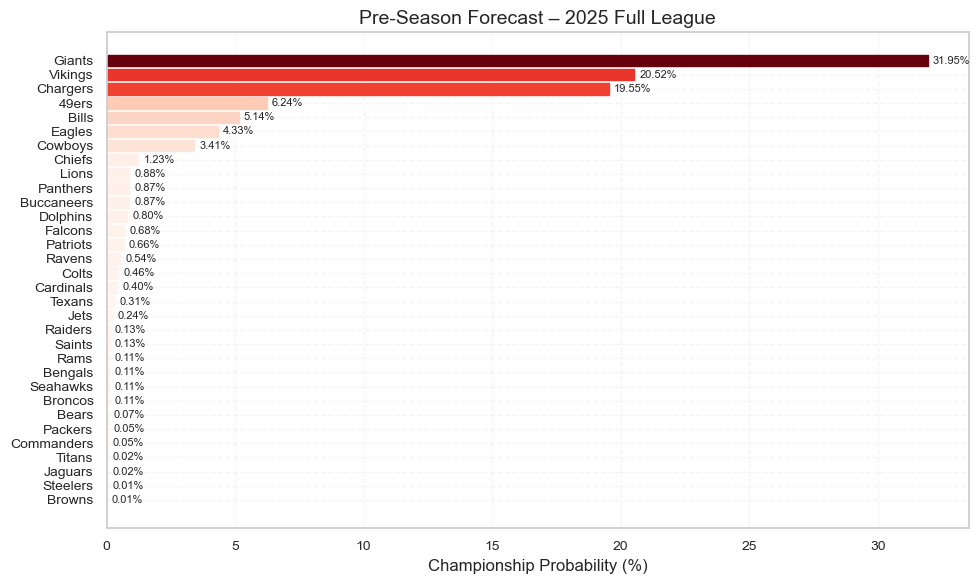

In [6]:
# Plots a horizontal bar chart of championship probabilities for top N teams.
def plot_probs(results_df, title, top_n=32):
    # Select top N teams with the highest championship probabilities
    top_teams_df = results_df.nlargest(top_n, "Championship Probability (%)")

    # Create horizontal bar plot
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    bars = plt.barh(top_teams_df["team"], top_teams_df["Championship Probability (%)"], edgecolor='black')

    # Color bars based on probability value
    for bar in bars:
        bar.set_color(plt.cm.Reds(bar.get_width() / max(top_teams_df["Championship Probability (%)"])))

    # Invert y-axis to place top team at the top
    plt.gca().invert_yaxis()
    
    plt.title(title, fontsize=14)
    plt.xlabel("Championship Probability (%)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(linestyle='--', alpha=0.2)

    # Add probability values to the end of bars
    for i, (prob) in enumerate(top_teams_df["Championship Probability (%)"]):
        plt.text(prob + 0.2, i, f"{prob:.2f}%", va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_probs(result_2025, title="Pre-Season Forecast – 2025 Full League")

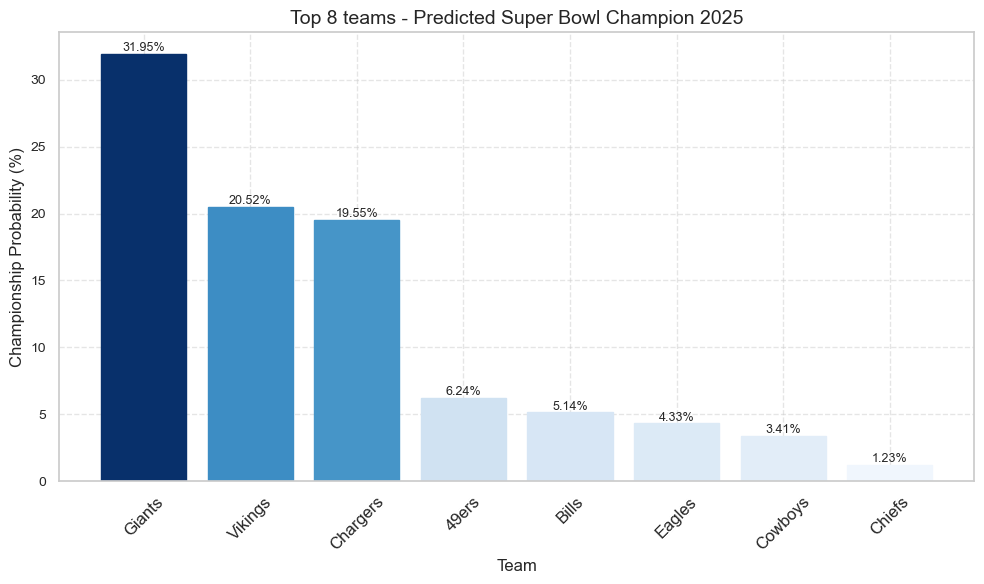

In [7]:
def plot_championship_bar_chart(df, title, prob_column="Championship Probability (%)", top_n=32):

    # Select top N teams with the highest championship probabilities
    data = df.nlargest(top_n, prob_column)

    # Create vertical bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(data["team"], data[prob_column], edgecolor='black')

    # Apply color gradient to bars based on height
    for bar in bars:
        bar.set_color(plt.cm.Blues(bar.get_height() / max(data[prob_column])))

    plt.title(title, fontsize=14)
    plt.xlabel("Team", fontsize=12)
    plt.ylabel(prob_column, fontsize=12)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=10)
    plt.grid(linestyle='--', alpha=0.5)

    # Add probability values above each bar
    for i, (team, prob) in enumerate(zip(data["team"], data[prob_column])):
        plt.text(i, prob + 0.2, f"{prob:.2f}%", ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

plot_championship_bar_chart(
    result_2025,
    title="Top 8 teams - Predicted Super Bowl Champion 2025",
    top_n=8
)

SHAP for champion team: Giants


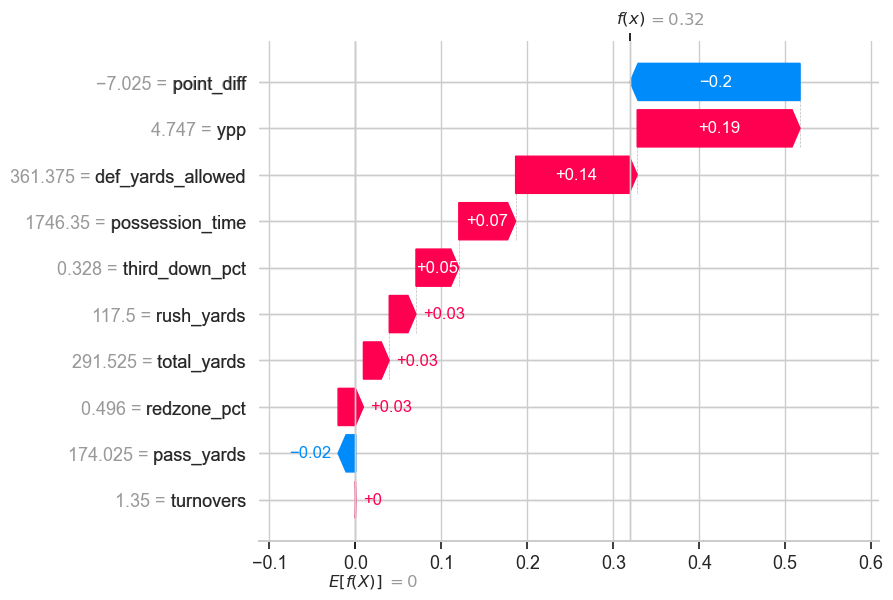

In [8]:
# Plots an adjusted SHAP waterfall chart for the predicted champion team in Scenario 3
def plot_combined_shap_for_team(playoff_model, champion_model, data, season, window, champion_team, normalised_prob):
    # Load test data
    season_data =get_season_data(data, season, window)

    # Extract features and team labels
    X = season_data.drop(columns=["team"])
    features = X.columns
    teams = season_data["team"].values  # Team labels for grouping SHAP values

    # Predict playoff and champion probabilities
    f1 = playoff_model.predict_proba(X)[:, 1]
    f2 = champion_model.predict_proba(X)[:, 1]
    
    # Compute SHAP values for both models
    explainer1 = shap.Explainer(playoff_model, X, model_output="probability")
    shap1 = explainer1(X).values
    
    explainer2 = shap.Explainer(champion_model, X, model_output="probability")
    shap2 = explainer2(X).values

    # Combine SHAP values using multiplication formula
    shap_combined_all = shap1 * f2[:, np.newaxis] + shap2 * f1[:, np.newaxis]

    # Create DataFrame of combined SHAP values and probabilities
    shap_df = pd.DataFrame(shap_combined_all, columns=features)
    shap_df["team"] = teams
    shap_df["prob"] = f1 * f2

    # Extract SHAP values for the champion team
    shap_row = shap_df[shap_df["team"] == champion_team][features].values.flatten()

    # Compute raw model output and scale to match normalised probability
    raw_fx = shap_row.sum()
    scaling_factor = normalised_prob / raw_fx
    shap_row_scaled = shap_row * scaling_factor

    # Get input feature values for the champion team
    team_input = X[season_data["team"] == champion_team].iloc[0].values

    # Plot the adjusted SHAP waterfall chart
    print(f"SHAP for champion team: {champion_team}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_row_scaled,
            base_values=0,
            data=team_input,
            feature_names=features
        )
    )

plot_combined_shap_for_team(
    playoff_model_2025, champion_model_2025, data,
    season=2025, window=4, champion_team="Giants", normalised_prob=0.3195
)